## Importing Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile
import os


#ignore warnings
import warnings
warnings.filterwarnings("ignore")


import sys
sys.path.append("..")
from latexify import latexify, format_axes
latexify(columns = 2)

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


## Downloading and Processing Audio

In [2]:
import os
import yt_dlp
from pydub import AudioSegment
import librosa
from IPython.display import Audio, display

def download_and_process_audio(url, temp_audio_file, cropped_audio_file, audio_dir, crop_start_ms, crop_end_ms):
    """
    Download an audio file from YouTube, crop it, and save it locally.

    Parameters:
    - url (str): The YouTube video URL.
    - temp_audio_file (str): The name of the temporary MP3 file (without extension).
    - cropped_audio_file (str): The name of the cropped WAV file (with extension).
    - audio_dir (str): The directory where the audio files will be saved.
    - crop_start_ms (int): Start time for cropping in milliseconds.
    - crop_end_ms (int): End time for cropping in milliseconds.
    """
    # Ensure the directory exists
    if not os.path.exists(audio_dir):
        os.makedirs(audio_dir)

    # Full paths for the audio files
    temp_audio_path = os.path.join(audio_dir, temp_audio_file + ".mp3")  # Add extension here
    cropped_audio_path = os.path.join(audio_dir, cropped_audio_file)

    # Download the audio file if it doesn't already exist
    if not os.path.exists(cropped_audio_path):
        print(f"{cropped_audio_file} not found. Downloading and cropping...")

        # yt-dlp options to download as .mp3
        ydl_opts = {
            'format': 'bestaudio/best',
            'postprocessors': [{
                'key': 'FFmpegExtractAudio',
                'preferredcodec': 'mp3',
                'preferredquality': '192',
            }],
            'outtmpl': os.path.join(audio_dir, temp_audio_file),  # No extension here
        }

        # Download the audio as .mp3
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])

        # Check if the file was downloaded successfully
        if os.path.exists(temp_audio_path):
            print(f"Audio downloaded and saved as: {temp_audio_path}")
        else:
            raise FileNotFoundError(f"Failed to download audio: {temp_audio_path}")

        # Load the downloaded mp3 audio
        audio = AudioSegment.from_mp3(temp_audio_path)

        # Crop the audio
        cropped_audio = audio[crop_start_ms:crop_end_ms]

        # Export the cropped audio as a .wav file
        cropped_audio.export(cropped_audio_path, format="wav")

        # Remove the temporary mp3 file
        os.remove(temp_audio_path)

        print(f"Cropped audio saved as {cropped_audio_file} in {audio_dir}.")
    else:
        print(f"{cropped_audio_file} already exists in {audio_dir}.")

    # Check if cropped audio exists before loading
    if os.path.exists(cropped_audio_path):
        # Load the cropped audio file
        audio_signal, sample_rate = librosa.load(cropped_audio_path, sr=None)  # sr=None to use the original sampling rate
        print("Audio loaded successfully.")
        # Play the original audio using IPython.display.Audio
        print("Playing cropped audio...")
        display(Audio(data=audio_signal, rate=sample_rate))
    else:
        raise FileNotFoundError(f"File {cropped_audio_path} not found.")


## Loading Audio

In [3]:
import os
import yt_dlp
from pydub import AudioSegment
import librosa
from IPython.display import Audio, display

# Define directory and crop parameters
audio_dir = os.path.join("..", "assets", "audio")

# URL and filenames for the first audio
url = "https://www.youtube.com/watch?v=ApXoWvfEYVU" # Sunflower by Post Malone
url = "https://www.youtube.com/watch?v=4JZ-o3iAJv4" # Oppenheimer by The Hamiltones


temp_audio_file = "tempaudiofile"
cropped_audio_file = "audio_cropped.wav"
crop_start_ms = 2000  # 2 seconds
crop_end_ms = 7000    # 7 seconds



# Process the first audio
download_and_process_audio(url, temp_audio_file, cropped_audio_file, audio_dir, crop_start_ms, crop_end_ms)



audio_cropped.wav already exists in ..\assets\audio.
Audio loaded successfully.
Playing cropped audio...


## Plotting Audio waveforms

In [4]:
def load_audio_librosa(file_path):
    """
    Load an audio file using librosa.

    Parameters:
    - file_path (str): Path to the audio file.

    Returns:
    - audio_signal (np.ndarray): Audio signal array.
    - sample_rate (int): Sampling rate of the audio.
    """
    audio_signal, sample_rate = librosa.load(file_path, sr=None)  # sr=None ensures original sampling rate is used
    print(f"Audio loaded successfully.")
    print(f"Signal shape: {audio_signal.shape} Sample rate: {sample_rate} Hz Audio duration:{len(audio_signal) / sample_rate} seconds")
    return audio_signal, sample_rate

def play_audio(file_path):
    """
    Play an audio file in Jupyter Notebook.

    Parameters:
    - file_path (str): Path to the audio file.
    """
    display(Audio(file_path, autoplay=True))

def audio_plot(audio, sr, clr, tl):
    """
    Plot the waveform of an audio signal.

    Parameters:
    - audio (np.ndarray): Audio signal array.
    - sr (int): Sampling rate of the audio.
    - clr (str): Color of the plot.
    - tl (str): Title of the plot.
    """
    plt.figure(figsize=(15, 4))
    ax = plt.gca()
    plt.plot(np.arange(len(audio)) / sr, audio, color=clr, alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    format_axes(ax)
    plt.show()

def audio_freq_plot(audio, sr, clr, tl):
    """
    Plot the frequency domain of an audio signal.

    Parameters:
    - audio (np.ndarray): Audio signal array.
    - sr (int): Sampling rate of the audio.
    - clr (str): Color of the plot.
    - tl (str): Title of the plot.
    """
    plt.figure(figsize=(15, 4))
    ax = plt.gca()
    plt.magnitude_spectrum(audio, Fs=sr, color=clr)
    plt.title(tl)
    plt.grid()
    format_axes(ax)
    plt.show()

$$ \text{Sampling Frequency} = \frac{\text{No. of Samples}}{\text{Time Taken}} $$

Audio loaded successfully.
Signal shape: (240000,) Sample rate: 48000 Hz Audio duration:5.0 seconds


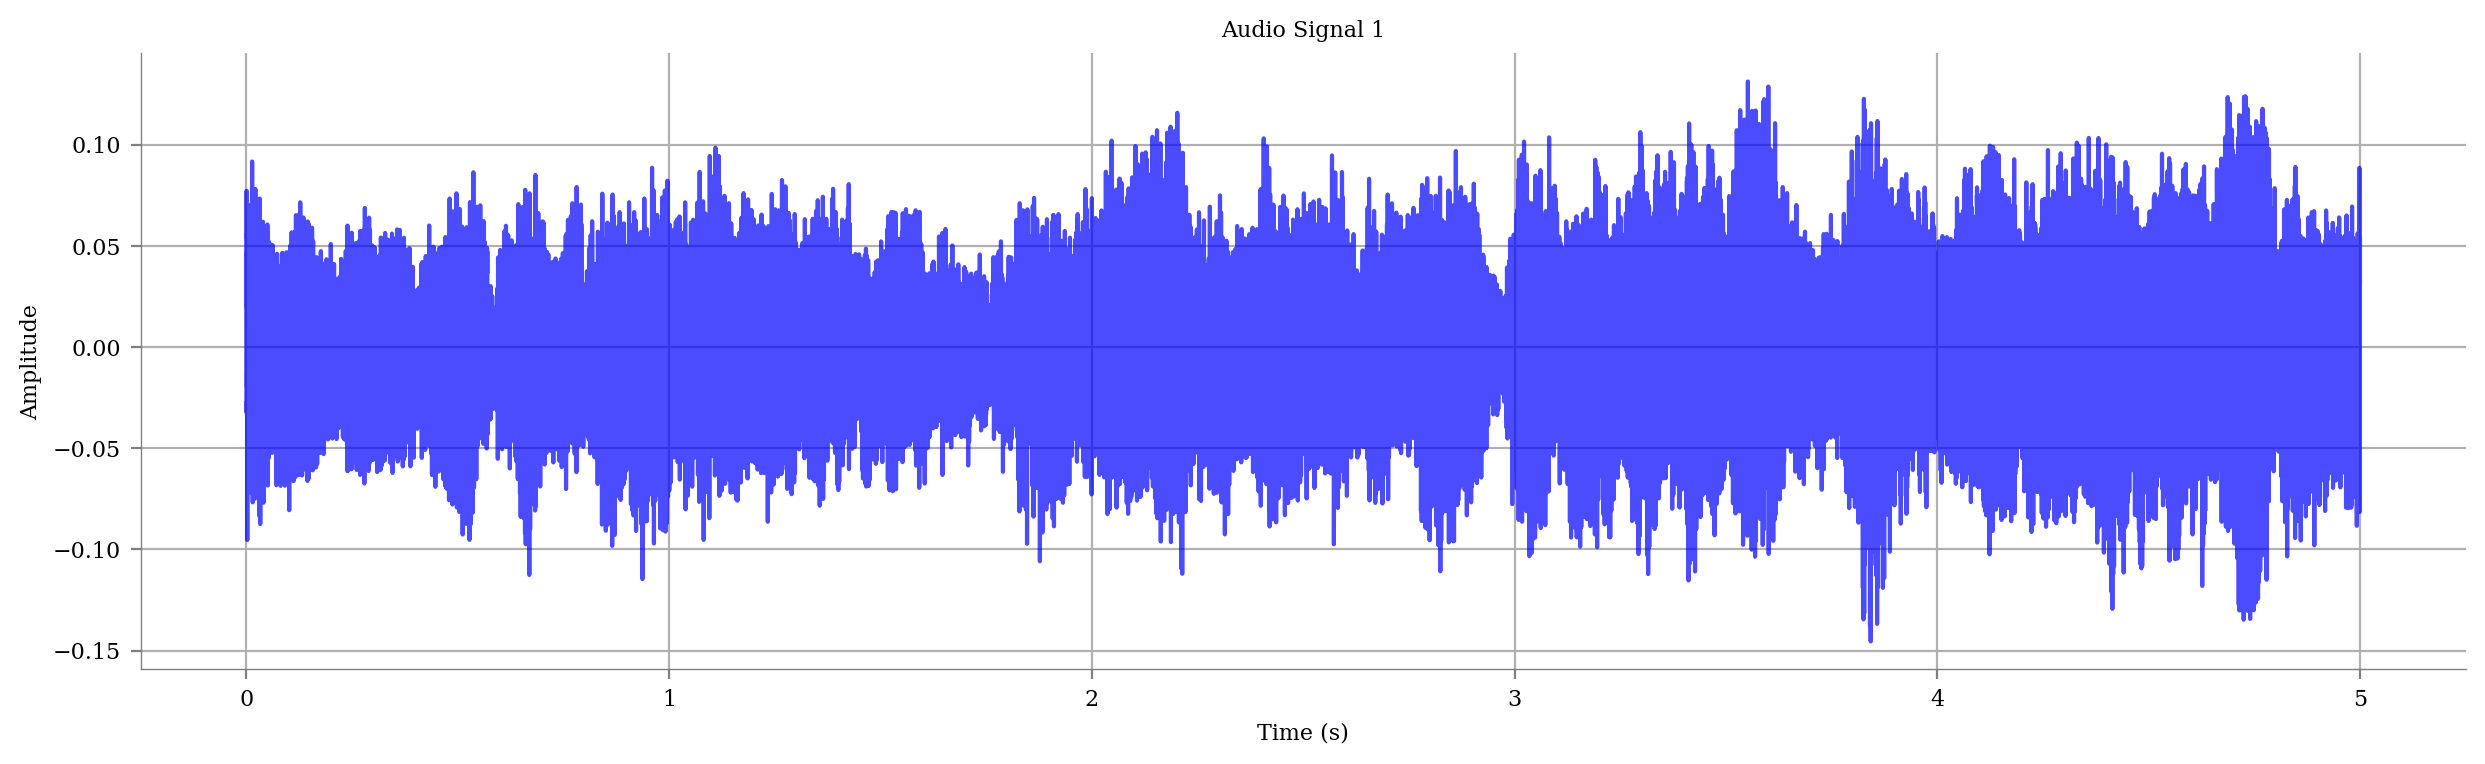

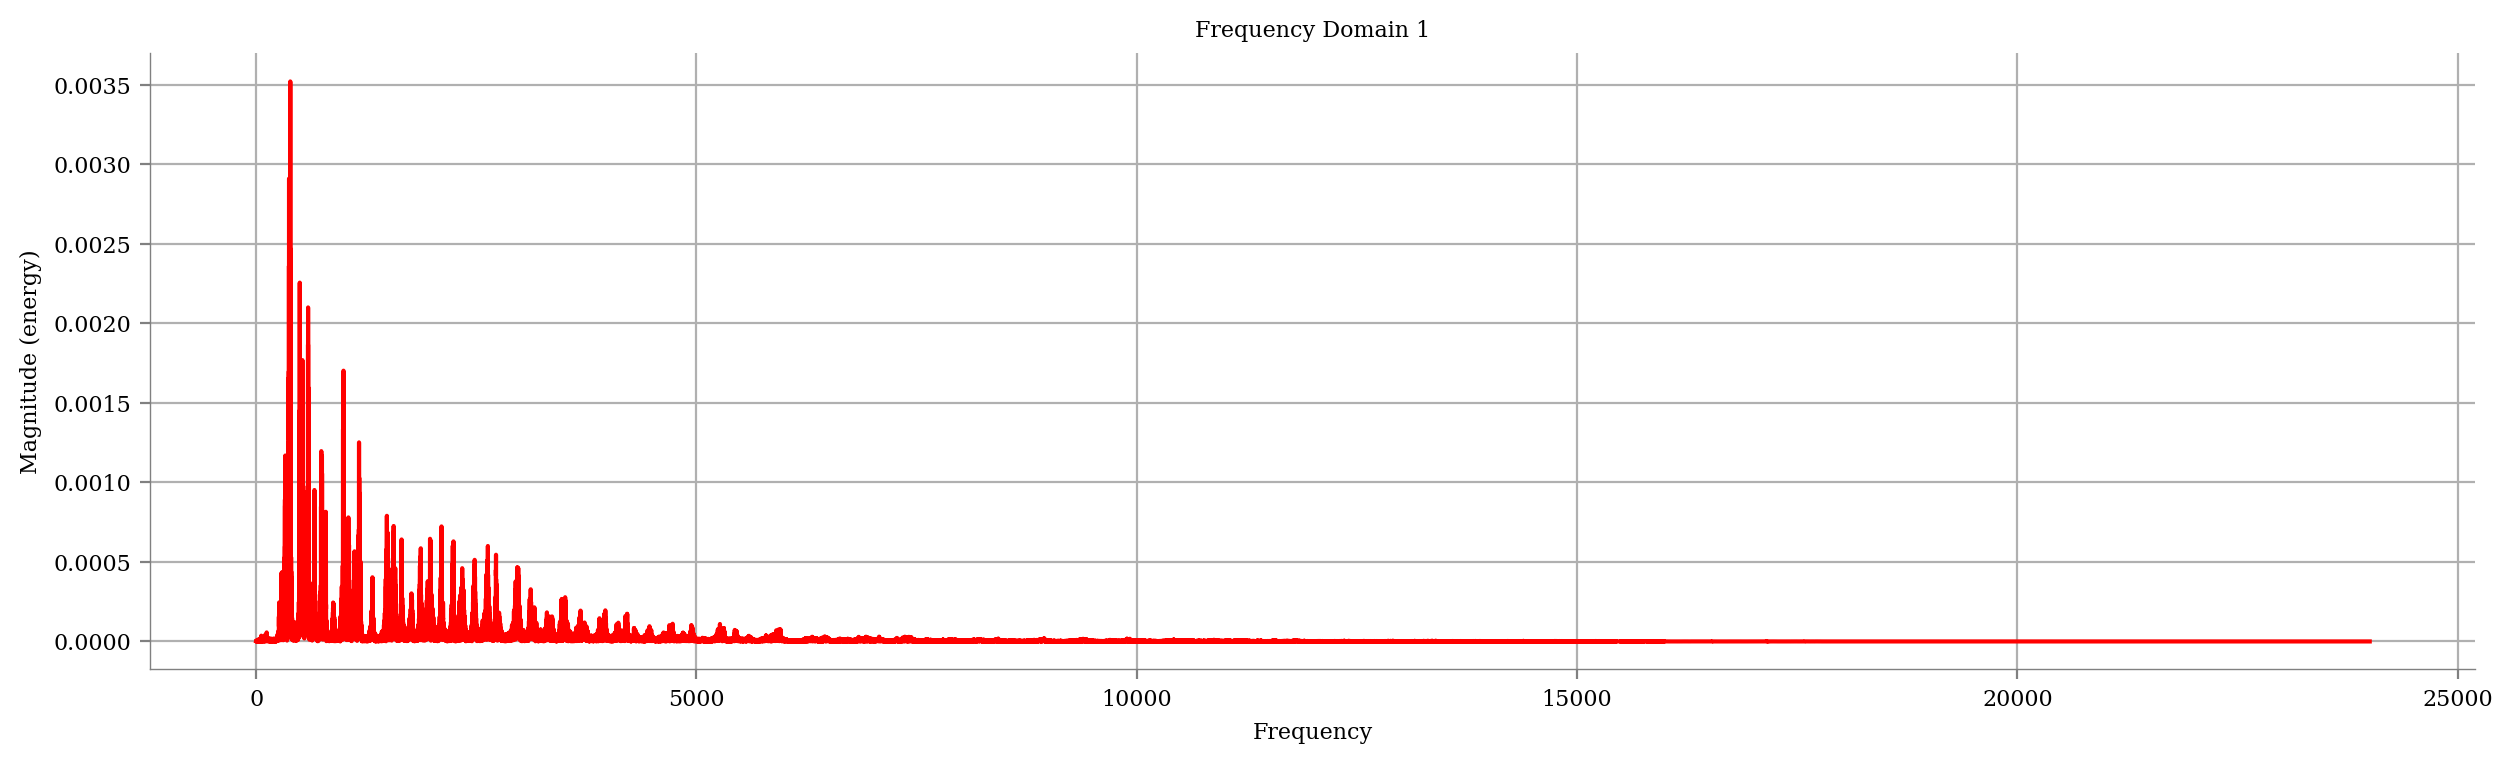

In [5]:

# Usage for the first audio file
file_path = "../assets/audio/audio_cropped.wav"
audio_signal, sample_rate = load_audio_librosa(file_path)
play_audio(file_path)
audio_plot(audio_signal, sample_rate, 'blue', 'Audio Signal 1')
audio_freq_plot(audio_signal, sample_rate, 'red', 'Frequency Domain 1')

### Creating the time series t=[-100.0,...,100.0] domain shifted to [-100,100]

In [6]:
# to creaste a time series
def create_time_series(audio):
    """
    Create a time series for the audio signal.

    Parameters:
    - audio (np.ndarray): Audio signal array.

    Returns:
    - X (torch.Tensor): Time series tensor.
    """

    X = torch.arange(0, len(audio)).unsqueeze(1).float()
    X = X / X.max() * 200 - 100
    print(X.shape)
    print(X)
    return X

# Create time series for the first audio signal
X = create_time_series(audio_signal)


torch.Size([240000, 1])
tensor([[-100.0000],
        [ -99.9992],
        [ -99.9983],
        ...,
        [  99.9983],
        [  99.9992],
        [ 100.0000]])


### Gaussian Kernel and Random Fourier Features

#### The Gaussian Kernel
$$ K(\textbf{x}, \textbf{x}') = \exp{(-\gamma \lVert \textbf{x} - \textbf{x}' \rVert^2)}, \gamma = \frac{1}{2\sigma^2}$$

#### Since this is infinte dimensional, it can approximated with the **Fourier Transform** of this kernel
###### _(Rahimi, A., & Recht, B. (2007). [Random features for large-scale kernel machines](https://papers.nips.cc/paper_files/paper/2007/hash/013a006f03dbc5392effeb8f18fda755-Abstract.html). Advances in Neural Information Processing Systems, 1177–1184.)_

$$\gamma(\mathbf{v}) = [\cos({2 \pi \mathbf{B}\mathbf{v}}), \sin({2 \pi \mathbf{B}\mathbf{v}})]^T $$
$$ \mathbf{v} \in \mathbb{R}^{\text{input}} $$
Each entry in $\mathbf{B} \in \mathbb{R}^{m \times \text{input}}$ is sampled from $\mathcal{N}(0, \sigma^2 I)$
$$ \gamma(\mathbf{v}) = [a_1 \cos({2 \pi \mathbf{b}_1^T\mathbf{v}}), a_1 \sin({2 \pi \mathbf{b}_1^T\mathbf{v}}), \cdots, a_m \cos({2 \pi \mathbf{b}_m^T\mathbf{v}}), a_m \sin({2 \pi \mathbf{b}_m^T\mathbf{v}})]^T $$

In [7]:
# Delete all unnecessary variables
del url, temp_audio_file, cropped_audio_file, crop_start_ms, crop_end_ms, file_path

In [8]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    print("Created RFF features with shape:", X.shape)
    return torch.tensor(X, dtype = torch.float32)

## Fit a linear model over this expanded feature domain

In [9]:
from sklearn.linear_model import LinearRegression

# create a function to call create_rff_featrures and then fit a linear model
def fit_rff_model(X, y, num_features, sigma):
    X_rff = create_rff_features(X, num_features, sigma)
    print("X_rff.shape:",X_rff.shape)
    print("y.shape:",y.shape)

    model = LinearRegression()
    model.fit(X_rff.numpy(),X)
    print("Model Coefficients:",model.coef_)

    pred_audio = model.predict(X_rff.numpy())
    print("Predicted audio shape:",pred_audio.shape)

    return model,pred_audio

# Fit the RFF model for the first audio signal
model_audio,pred_audio = fit_rff_model(X, audio_signal, 5000, 0.008)

Created RFF features with shape: (240000, 5000)
X_rff.shape: torch.Size([240000, 5000])
y.shape: (240000,)
Model Coefficients: [[ 7.4171677e-02  1.0396448e+00 -8.0302597e+01 ... -9.7128191e+00
  -1.8193905e+00  6.7315936e-01]]
Predicted audio shape: (240000, 1)


## Saving the model weights and sound file

In [10]:
import joblib
if not os.path.exists("../assets/models"):
    os.makedirs("../assets/models")
# if the model is already present then don't dump it again
if not os.path.exists("../assets/models/model_audio.joblib"):
    joblib.dump(model_audio, "../assets/models/model_audio.joblib")

print("Model saved successfully.")

# delete all unnecessary variables
del model_audio, pred_audio

Model saved successfully.


## Load the models

In [11]:
#Load the model
model_audio = joblib.load(f"../assets/models/model_audio.joblib")

print("Model loaded successfully.")

Model loaded successfully.


In [12]:

# Predict the audio signal using the model
pred_audio = model_audio.predict(create_rff_features(X, 5000, 0.008).numpy())

#Save the predicted audio
if not os.path.exists("../assets/audio"):
    os.makedirs("../assets/audio")
soundfile.write(f"../assets/audio/pred_audio.wav", pred_audio, sample_rate)

# Play the predicted audio
print("Playing the predicted audio...")
play_audio(f"../assets/audio/pred_audio.wav")

Created RFF features with shape: (240000, 5000)
Playing the predicted audio...


### Reconstruction Losses ($L_1$ and $L_2$)
$$ L_1 = \lVert \text{Reconstructed} - \text{Original} \rVert_1 $$
$$ L_2 = \lVert \text{Reconstructed} - \text{Original} \rVert_2 $$

In [13]:
# clear gc
import gc
gc.collect()

3046

In [14]:
import numpy as np
def calculate_error(audio, pred_audio, ord=1):
    """
    Calculate the L2 and L1 norm errors between the original and predicted audio signals.

    Parameters:
    - audio (np.ndarray): Original audio signal.
    - pred_audio (np.ndarray): Predicted audio signal.

    Returns:
    - l2_error (float): L2 norm error.
    - l1_error (float): L1 norm error.
    """
    # Flatten pred_audio if it is 2D
    if pred_audio.ndim == 2:
        pred_audio = pred_audio.flatten()

    if audio.shape != pred_audio.shape:
        raise ValueError("Shape mismatch: audio and pred_audio must have the same shape.")
    
    # Ensure audio and pred_audio are 1D arrays
    audio = audio.flatten()
    pred_audio = pred_audio.flatten()
    
    l2_error = np.linalg.norm(pred_audio - audio)
    l1_error = np.linalg.norm(pred_audio - audio, ord=ord)
    
    return l2_error, l1_error

    
# Calculate the errors for the first audio signal
l2_error, l1_error = calculate_error(audio_signal, pred_audio)
print("L2 error for audio 1:", l2_error)
print("L1 error for audio 1:", l1_error)

L2 error for audio 1: 23285.848
L1 error for audio 1: 10395726.0


## Reconstructed Audio

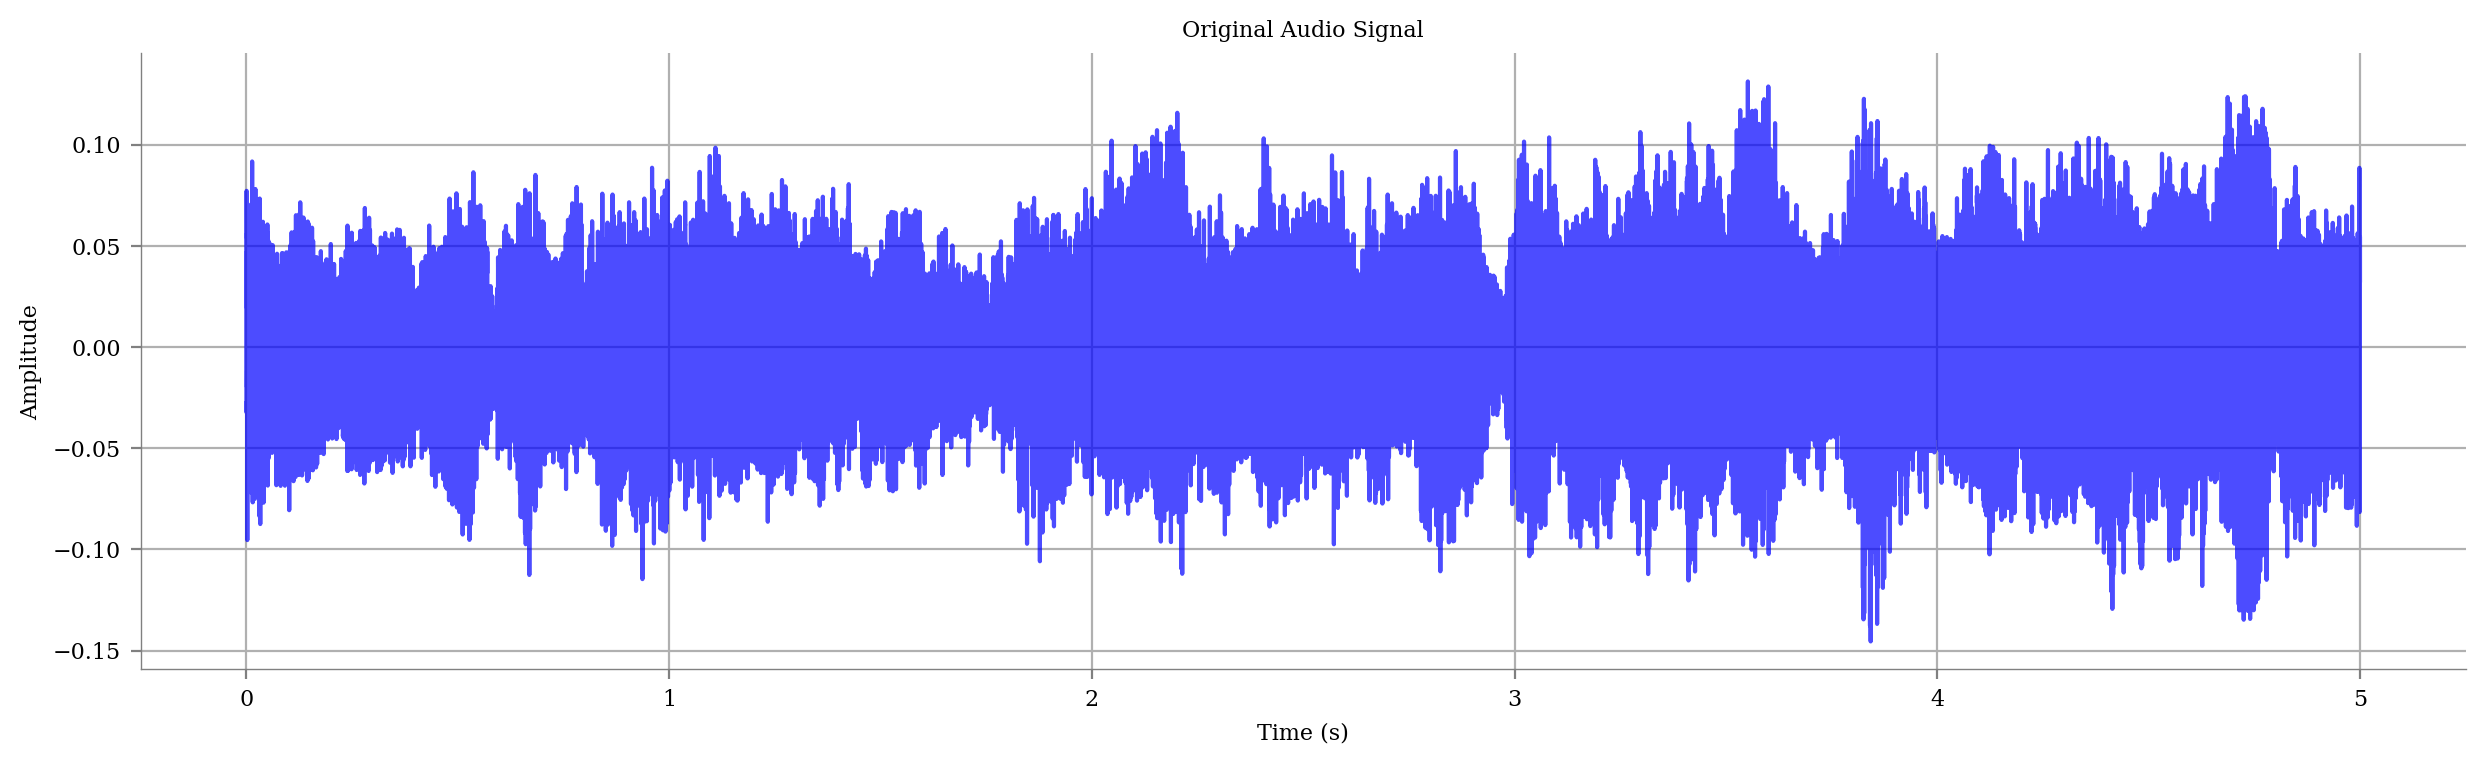

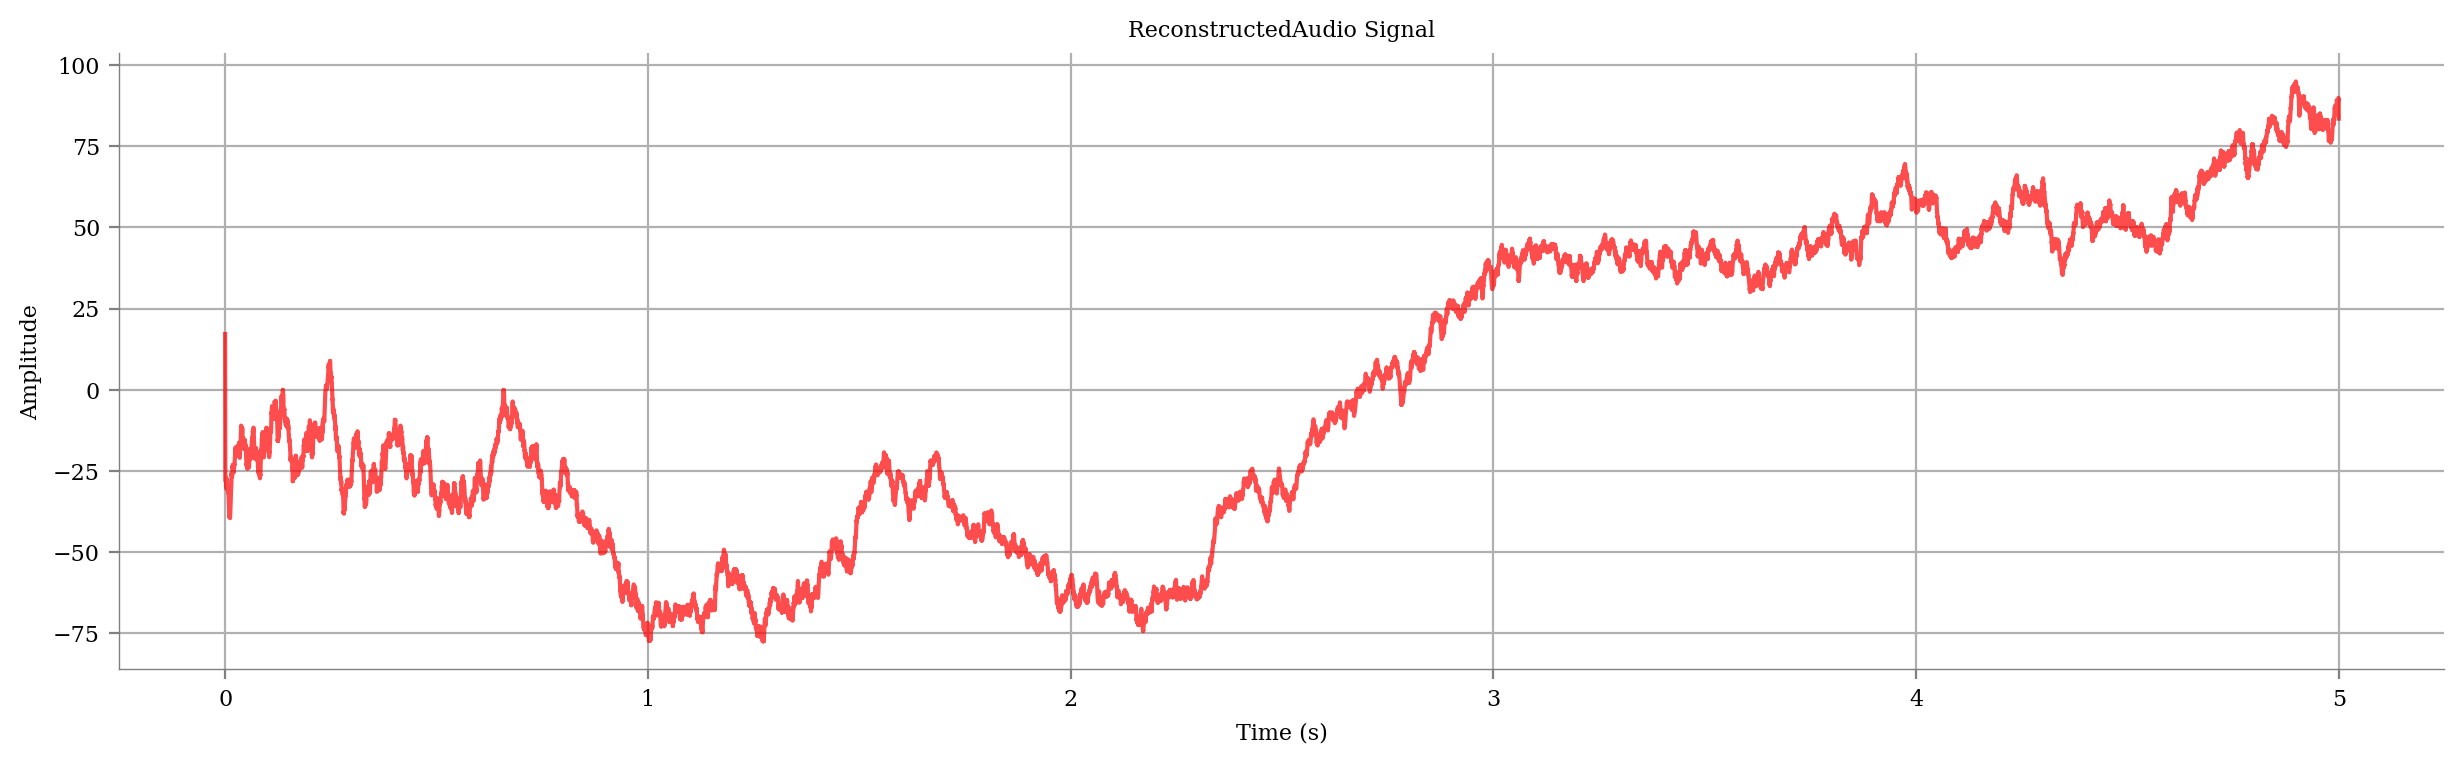

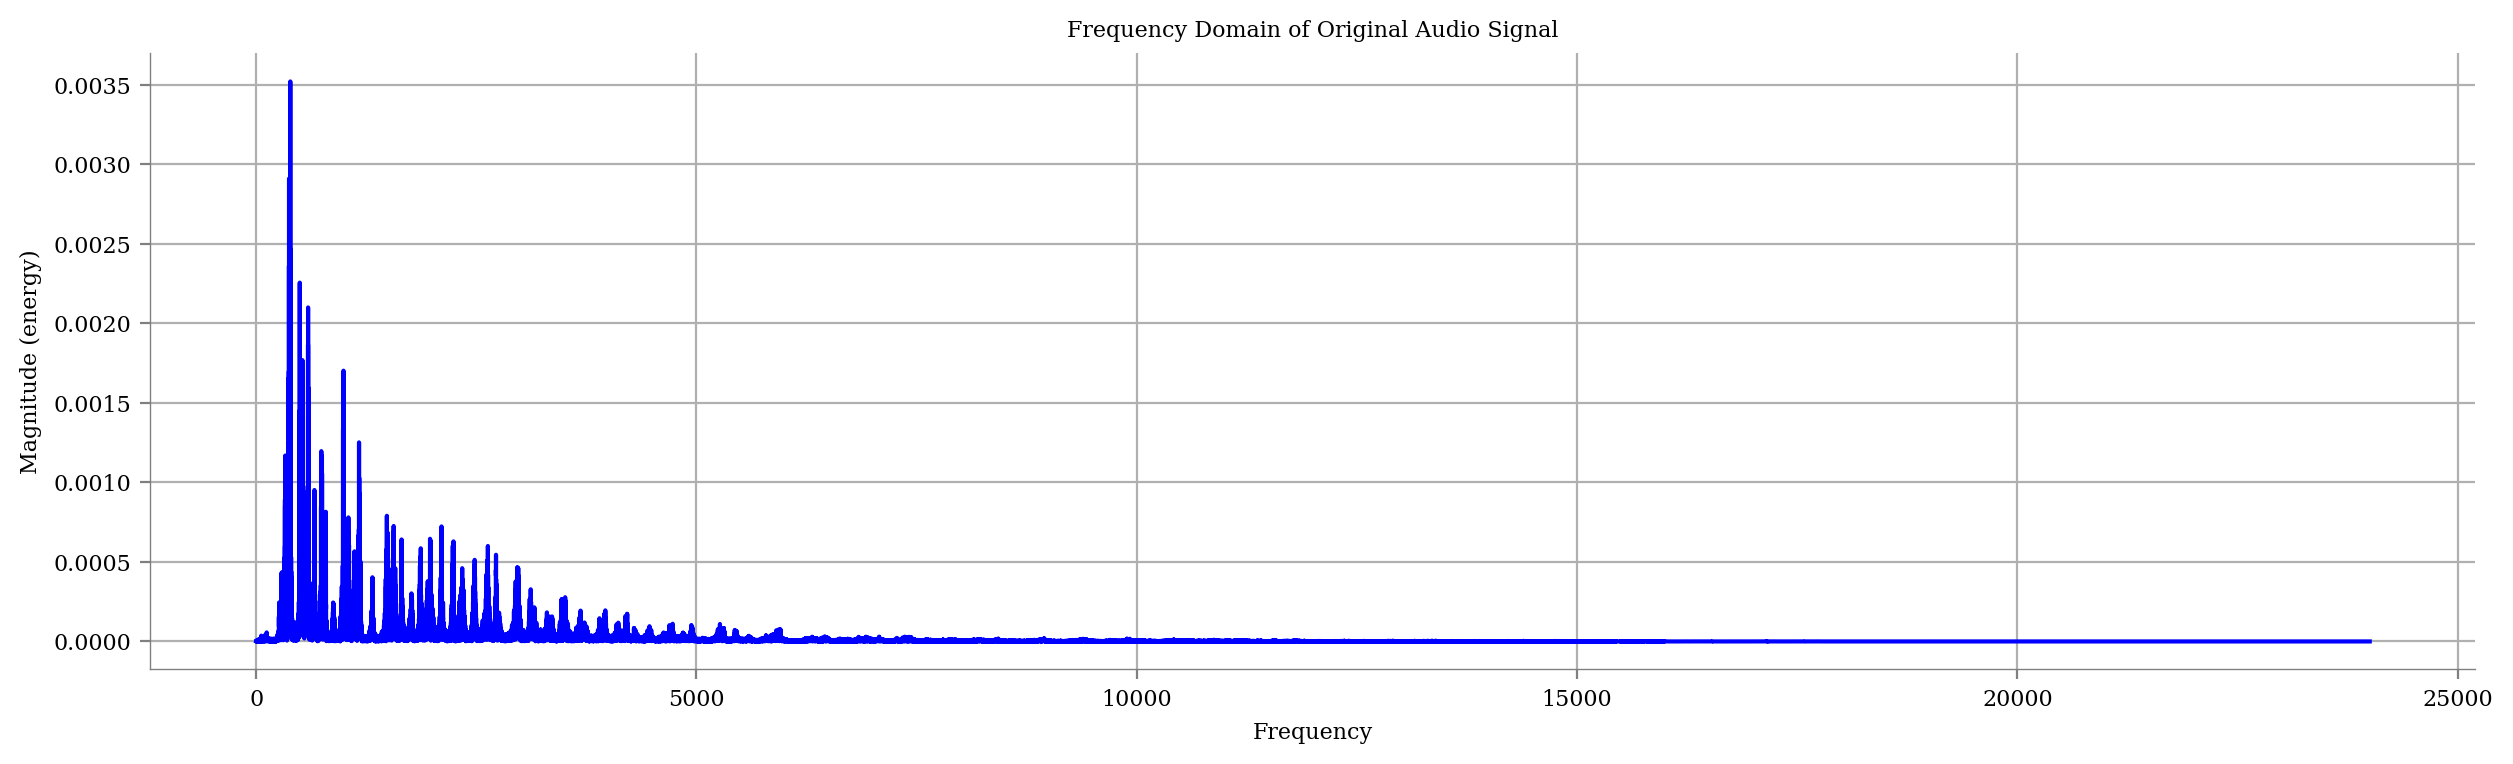

In [15]:
audio_plot(audio_signal, sample_rate, 'blue', 'Original Audio Signal')  # Original audio signal
audio_plot(pred_audio, sample_rate, 'red', 'ReconstructedAudio Signal')  # Predicted audio signal 
audio_freq_plot(audio_signal, sample_rate, 'blue', 'Frequency Domain of Original Audio Signal')  # Frequency domain of original audio signal    

In [ ]:
# function to plot the original and reconstructed audio signals together
def plot_compare(audio, pred_audio):
    """
    Plot the original and reconstructed audio signals together.

    Parameters:
    - audio (torch.Tensor): Original audio signal.
    - pred_audio (np.ndarray): Predicted audio signal.
    """
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color='blue', alpha=0.7, label='Original Audio')
    plt.plot(pred_audio, color='red', alpha=0.7, label='Reconstructed Audio')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Original vs Reconstructed Audio Waveform')
    plt.grid()
    plt.legend()
    plt.show()

plot_compare(audio_signal, pred_audio)

## Interpolation

### Interpolation

#### We remove out 10,000 continuous samples from the time series
#### $\textbf{X}_{(:\text{start}, 5000) \cup (\text{end}:, 5000)}, \textbf{y}_{(:\text{start},) \cup (\text{end}:,)}$

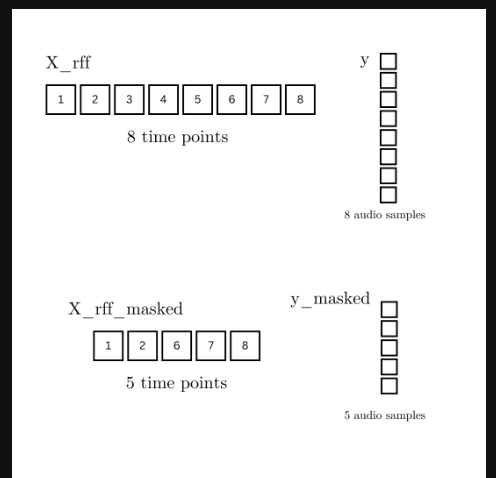

In [ ]:
# function to perform audio interpolation
def interpolate_audio(audio, start_idx, end_idx):
    """
    Interpolate the audio signal between the start and end indices.

    Parameters:
    - audio (torch.Tensor): Original audio signal.
    - pred_audio (np.ndarray): Predicted audio signal.
    - start_idx (int): Start index for interpolation.
    - end_idx (int): End index for interpolation.

    Returns:
    - audio_new (torch.Tensor): Interpolated audio signal.
    """
    audio_new = audio.clone()
    audio_new[start_idx:end_idx] = 0
    return audio_new

start_idx = 20000
end_idx = 30000

audio_signal1_new = interpolate_audio(audio_signal, start_idx, end_idx)

# function to plot the interpolated audio signal
def plot_interpolated_audio(audio, audio_new, start_idx, end_idx):
    """
    Plot the original and interpolated audio signals.

    Parameters:
    - audio (torch.Tensor): Original audio signal.
    - audio_new (torch.Tensor): Interpolated audio signal.
    - start_idx (int): Start index for interpolation.
    - end_idx (int): End index for interpolation.
    """
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color='blue', alpha=0.7, label='Original Audio')
    plt.plot(audio_new, color='red', alpha=0.7, label='Interpolated Audio')
    plt.axvline(start_idx, color='green', linestyle='--', label=f'Start Index: {start_idx}')
    plt.axvline(end_idx, color='green', linestyle='--', label=f'End Index: {end_idx}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Interpolated Audio Waveform')
    plt.grid()
    plt.legend()
    plt.show()

plot_interpolated_audio(audio_signal, audio_signal1_new, start_idx, end_idx)


#### Extract out the $\textbf{X}[:\text{start}]$ $\textbf{X}[\text{end}:]$, $\textbf{y}[:\text{start}]$  $\textbf{y}[\text{end}:]$ and then concatentate them

In [ ]:
# function to  Extract out the X[:start]X[end:] and audio[:start]audio[end:] and then concate them
def extract_and_concat(X, audio, start_idx, end_idx):
    """
    Extract out the X[:start]X[end:] and audio[:start]audio[end:] and then concate them.

    Parameters:
    - X (torch.Tensor): Time series tensor.
    - audio (torch.Tensor): Original audio signal.
    - start_idx (int): Start index for extraction.
    - end_idx (int): End index for extraction.

    Returns:
    - X_new (torch.Tensor): Concatenated time series tensor.
    - audio_new (torch.Tensor): Concatenated audio signal.
    """
    X1 = X[:start_idx]
    X2 = X[end_idx:]

    audio1 = audio[:start_idx]
    audio2 = audio[end_idx:]

    X_new = torch.cat((X1, X2), dim=0)
    print("X_new.shape:",X_new.shape)
    audio_new = torch.cat((audio1, audio2), dim=0)
    print("audio_new.shape:",audio_new.shape)

    return X_new, audio_new

# Extract and concatenate the  audio signal
X_new, audio_signal_new = extract_and_concat(X, audio_signal, start_idx, end_idx)

### Fit the Linear model on the left out portion `X_rffF`